# Project: Time Series Analysis
-----------------------------------------
**Creating short term temperature forecasts**

**by Karin**


### Import libraries

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

plt.rcParams['figure.figsize'] = (14,6)

### Read the temperature data for Berlin-Tempelhof from EUROPEAN CLIMATE ASSESSMENT & DATASET (ECA&D)

In [89]:
# Read data and get info about datatypes, NaNs:
df=pd.read_csv('Berlin-Tempelhof_mean-temp.txt', index_col=1,parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52900 entries, 1876-01-01 to 2020-10-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   SOUID   52900 non-null  int64
 1   TG      52900 non-null  int64
 2   Q_TG    52900 non-null  int64
dtypes: int64(3)
memory usage: 1.6 MB


### Plot the target:

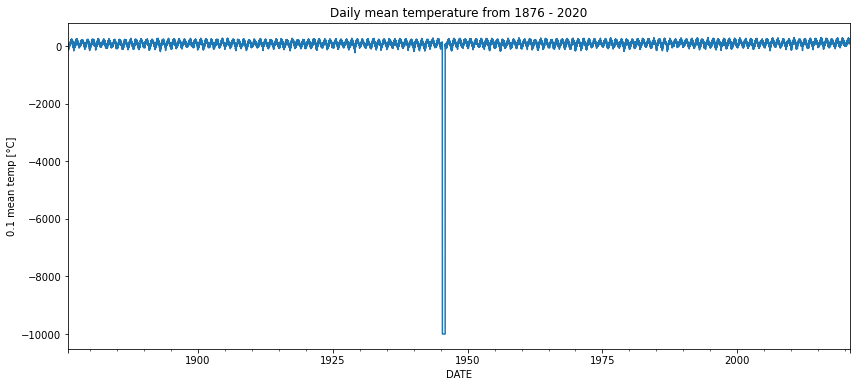

In [86]:
# Plot temperature (target):
df['TG'].plot()
plt.title('Daily mean temperature from 1876 - 2020')
plt.ylabel('0.1 mean temp [°C]'); #invalid data in 1945

### Clean the data

In [87]:
#Cut off data before 1946:
df = df.loc['1.1.1946':]
#Add column with actual temp in °Celsius:
df['temp'] = df['TG']*0.1
#Drop unnecessary columns:
df = pd.DataFrame(df['temp'])
df.head()

temp
DATE            
1946-01-01  -3.4
1946-01-02  -3.0
1946-01-03  -2.8
1946-01-04  -2.7
1946-01-05   1.4

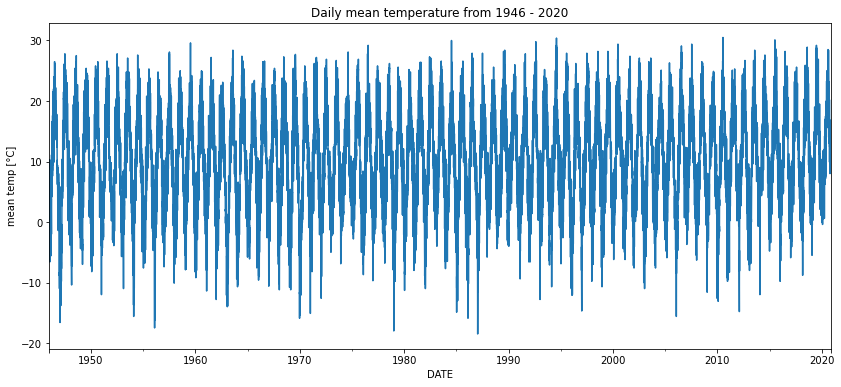

In [33]:
def plot_temp(df, title = 'Daily mean temperature from 1946 - 2020'):
    df.plot(legend=False)
    plt.title(title)
    plt.ylabel('mean temp [°C]')

plot_temp(df)

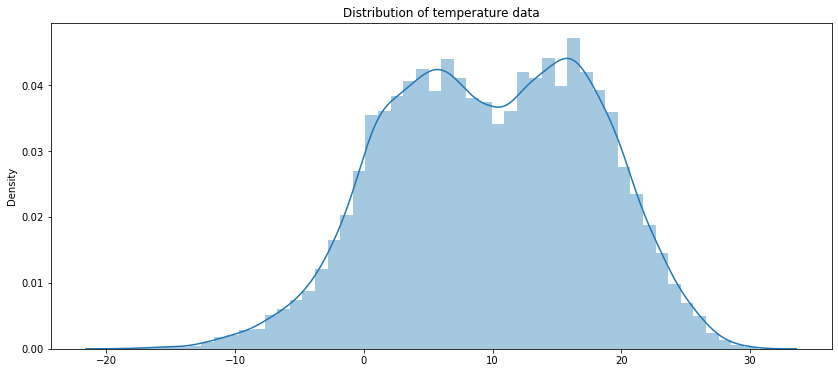

In [34]:
# Temperature data is more or less normally distributed:
sns.distplot(df)
plt.title('Distribution of temperature data');

### Model the overall trend

In [35]:
# Create timestep column:
df['timestep'] = list(range(len(df)))
df.head()

temp  timestep
DATE                      
1946-01-01  -3.4         0
1946-01-02  -3.0         1
1946-01-03  -2.8         2
1946-01-04  -2.7         3
1946-01-05   1.4         4

In [36]:
# Run a Linear Regression on timestep data:
lr_timestep = LinearRegression()
X = df[['timestep']]
y = df['temp']
lr_timestep.fit(X, y)

LinearRegression()

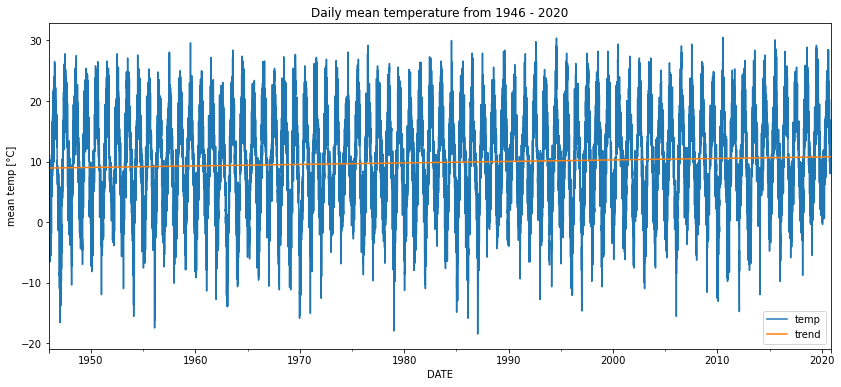

In [37]:
# Create new column with prediction from timestep model:
df['trend'] = lr_timestep.predict(X)
plot_temp(df[['temp', 'trend']])
plt.legend()

### Model the seasonality

In [38]:
# One-Hot-Encoding the week:
week_dummies = pd.get_dummies(df.index.weekofyear,
                                  prefix='week',
                                  drop_first=True).set_index(df.index)

df = df.join(week_dummies)
df.head(3)

temp  timestep     trend  week_2  week_3  week_4  week_5  week_6  \
DATE                                                                           
1946-01-01  -3.4         0  8.925355       0       0       0       0       0   
1946-01-02  -3.0         1  8.925423       0       0       0       0       0   
1946-01-03  -2.8         2  8.925491       0       0       0       0       0   

            week_7  week_8  ...  week_44  week_45  week_46  week_47  week_48  \
DATE                        ...                                                
1946-01-01       0       0  ...        0        0        0        0        0   
1946-01-02       0       0  ...        0        0        0        0        0   
1946-01-03       0       0  ...        0        0        0        0        0   

            week_49  week_50  week_51  week_52  week_53  
DATE                                                     
1946-01-01        0        0        0        0        0  
1946-01-02        0        0        0        0        0  
1946-01-03        0        0        0        0        0  

[3 rows x 55 columns]

### Train-test-split before modelling seasonality

In [39]:
# Use the last year as test dataset and the previous data as training set
df_train = df[:-365]
df_test = df[-365:]

In [40]:
# Run a Linear Regression on timestep and dummie data:
lr_seasonal = LinearRegression()
X = df_train.drop(columns=['temp', 'trend'])
y = df_train['temp']
lr_seasonal.fit(X, y)
round(lr_seasonal.score(X, y),2)

0.77

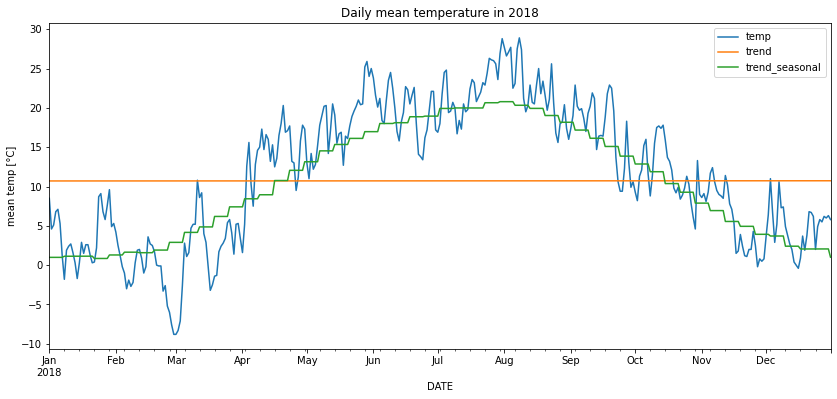

In [41]:
#Create new column with prediction from seasonal model:
df_train['trend_seasonal'] = lr_seasonal.predict(X)
plot_temp(df_train.loc['1.1.2018':'31.12.2018'][['temp', 'trend', 'trend_seasonal']], title='Daily mean temperature in 2018')
plt.legend();

### Model the time dependence

In [42]:
# Extract the remainder, which is the part that cannot be explained by trend and seasonality:
df_train['remainder'] = df_train['temp'] - df_train['trend_seasonal']

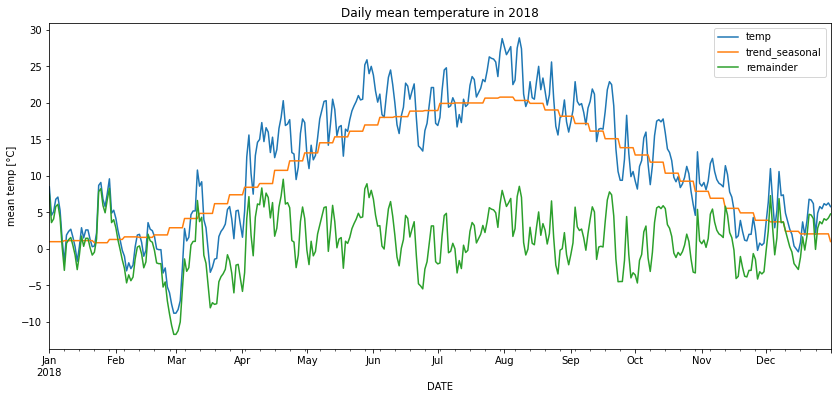

In [43]:
plot_temp(df_train.loc['1.1.2018':'31.12.2018'][['temp','trend_seasonal','remainder']],title='Daily mean temperature in 2018')
plt.legend();

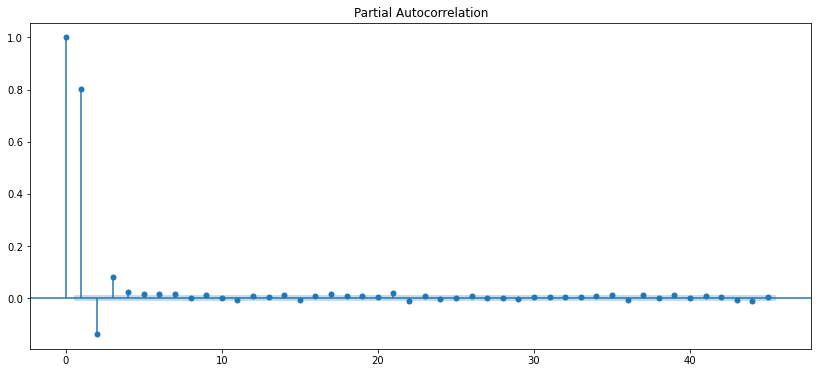

In [44]:
#Inspect the partial autocorrelation of the remainder to decide how many lags to use for the model:
plot_pacf(df_train['remainder']);

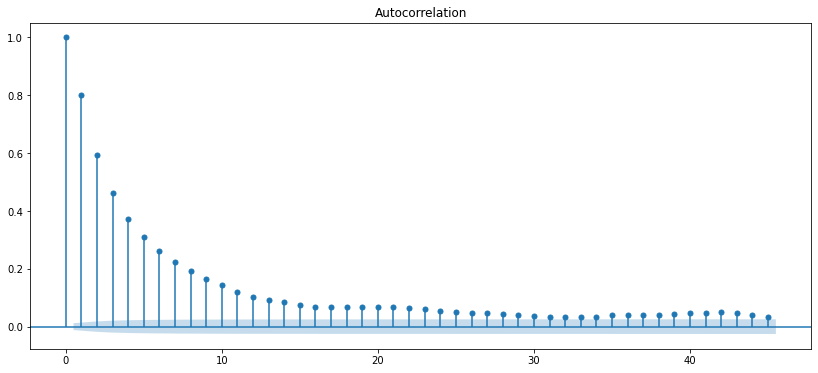

In [45]:
#Also inspect the autocorrelation:
plot_acf(df_train['remainder']);

### Choose the number of lags

In [46]:
selected_order = ar_select_order(df_train['remainder'], maxlag=10)

/Users/karin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/karin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [47]:
selected_order.ar_lags

array([1, 2, 3, 4])

### Fit AR and ARIMA model to see which one is better in predicting the remainder

In [48]:
ar_model = AutoReg(df_train['remainder'], lags=4).fit()

/Users/karin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [49]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                26968
Model:                     AutoReg(4)   Log Likelihood              -60153.232
Method:               Conditional MLE   S.D. of innovations              2.252
Date:                Thu, 17 Dec 2020   AIC                              1.624
Time:                        23:21:41   BIC                              1.626
Sample:                    01-05-1946   HQIC                             1.625
                         - 11-01-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept     1.387e-07      0.014   1.01e-05      1.000      -0.027       0.027
remainder.L1     0.9217      0.006    151.390      0.000       0.910       0.934
remainder.L2    -0.2068      0.008    -24.995      0.000      -0.223      -0.191
remainder.L3     0.0602      0.008      7.282      0.000       0.044       0.076
remainder.L4     0.0232      0.006      3.814      0.000       0.011       0.035
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2461           -0.0000j            1.2461           -0.0000
AR.2            0.9055           -2.3011j            2.4729           -0.1903
AR.3            0.9055           +2.3011j            2.4729            0.1903
AR.4           -5.6514           -0.0000j            5.6514           -0.5000
-----------------------------------------------------------------------------
"""

In [50]:
arima_model = ARIMA(df_train['remainder'], order=(4,1,3)).fit() # order is (p,d,q) or (ar,i,ma)

/Users/karin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/karin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/karin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/karin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [51]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              remainder   No. Observations:                26968
Model:                 ARIMA(4, 1, 3)   Log Likelihood              -60154.264
Date:                Thu, 17 Dec 2020   AIC                         120324.528
Time:                        23:21:58   BIC                         120390.147
Sample:                    01-01-1946   HQIC                        120345.690
                         - 11-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5181      1.534      0.990      0.322      -1.488       4.524
ar.L2         -0.8085      1.979     -0.408      0.683      -4.688       3.071
ar.L3          0.2255      0.841      0.268      0.789      -1.423       1.874
ar.L4         -0.0274      0.197     -0.139      0.889      -0.413       0.358
ma.L1         -1.5920      1.534     -1.038      0.299      -4.599       1.415
ma.L2          0.6425      2.094      0.307      0.759      -3.461       4.746
ma.L3         -0.0492      0.564     -0.087      0.931      -1.155       1.057
sigma2         5.0599      0.038    131.918      0.000       4.985       5.135
===================================================================================
Ljung-Box (Q):                       52.34   Jarque-Bera (JB):               576.55
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

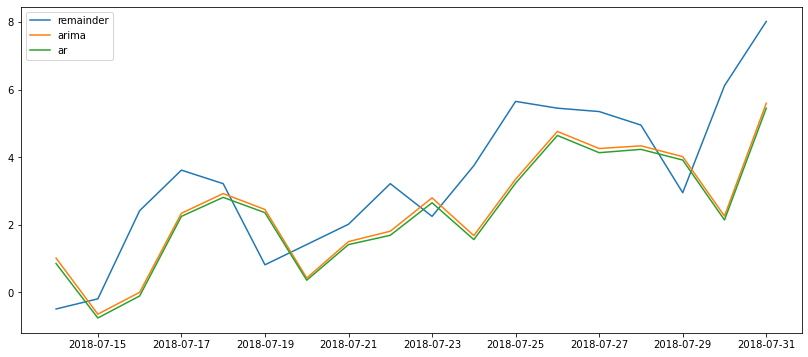

In [52]:
# Both models perform equally
plt.plot(df_train.loc['14.07.2018':'31.07.2018'][['remainder']], label='remainder')
plt.plot(arima_model.predict().loc['14.7.2018':'31.07.2018'], label='arima')
plt.plot(ar_model.predict()['14.7.2018':'31.07.2018'], label='ar')
plt.legend()

### Create 4 lags based on the results above

In [53]:
#Create 4 lag columns:
df_train['lag1'] = df_train['remainder'].shift(1)
df_train['lag2'] = df_train['remainder'].shift(2)
df_train['lag3'] = df_train['remainder'].shift(3)
df_train['lag4'] = df_train['remainder'].shift(4)

<AxesSubplot:>

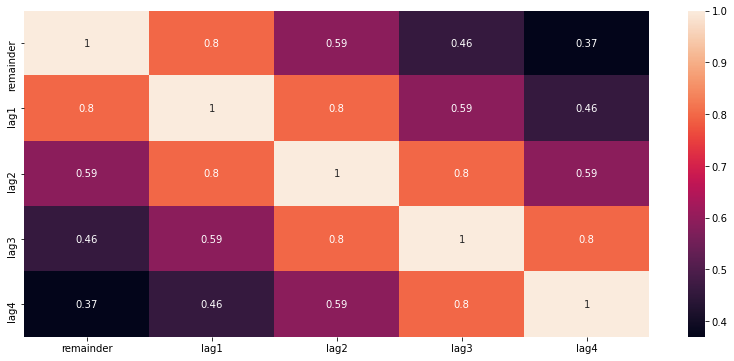

In [54]:
#Another way to look at the autocorrelation of lags and remainder:
sns.heatmap(round(df_train[['remainder','lag1', 'lag2', 'lag3', 'lag4']].corr(), 2), annot=True)

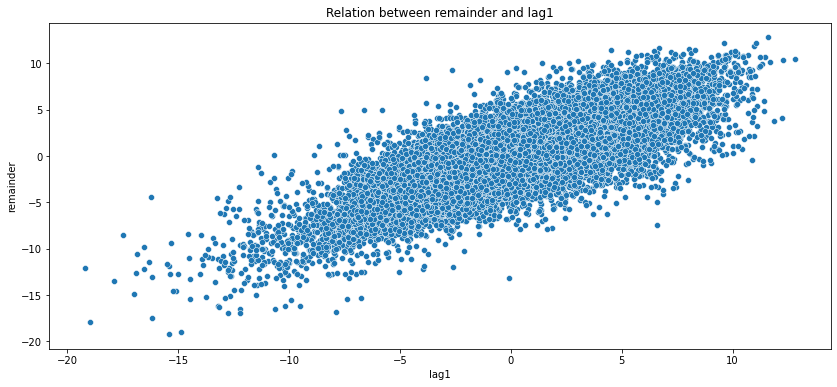

In [58]:
sns.scatterplot(x='lag1', y = 'remainder', data=df_train)
plt.title('Relation between remainder and lag1');

### Test for stationarity

In [93]:
#Testing for stationarity with Dickie-Fuller-Test (if p is small, the remainder is stationary):
import statsmodels
from statsmodels.tsa import stattools
def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
    statsmodels.tsa.stattools.adfuller(data)
    
    print(f"""
    adf_stats: {adf_stats}
    p: {p} 
    used lag: {used_lag} 
    number of observations: {n_obs}
    CI 99%: {levels['1%']}
    CI 95%: {levels['5%']}
    CI 90%: {levels['10%']}
    information criterion (AIC): {information_criterion}
            """)
print_adf(df_train['remainder'])


    adf_stats: -27.51739452163928
    p: 0.0 
    used lag: 21 
    number of observations: 26946
    CI 99%: -3.4305927047821196
    CI 95%: -2.8616472685067995
    CI 90%: -2.566827095830384
    information criterion (AIC): 120082.27841152556
            


In [60]:
#Drop rows with NaN values, that were created in the lag columns:
df_train.dropna(inplace = True)
df_train.head(3)

temp  timestep     trend  week_2  week_3  week_4  week_5  week_6  \
DATE                                                                           
1946-01-05   1.4         4  8.925626       0       0       0       0       0   
1946-01-06   1.9         5  8.925694       0       0       0       0       0   
1946-01-07   0.4         6  8.925762       1       0       0       0       0   

            week_7  week_8  ...  week_50  week_51  week_52  week_53  \
DATE                        ...                                       
1946-01-05       0       0  ...        0        0        0        0   
1946-01-06       0       0  ...        0        0        0        0   
1946-01-07       0       0  ...        0        0        0        0   

            trend_seasonal  remainder      lag1      lag2      lag3      lag4  
DATE                                                                           
1946-01-05       -0.547319   1.947319 -2.152622 -2.252564 -2.452505 -2.852446  
1946-01-06       -0.547261   2.447261  1.947319 -2.152622 -2.252564 -2.452505  
1946-01-07       -0.406594   0.806594  2.447261  1.947319 -2.152622 -2.252564  

[3 rows x 61 columns]

## Train the main model
**Takes trend, seasonality and time dependence into account**

In [69]:
# Train a model with timestep, dummies and lags:
lr_all = LinearRegression()
X_train = df_train.drop(columns=['temp', 'trend', 'trend_seasonal', 'remainder'])
y_train = df_train['temp']
lr_all.fit(X_train, y_train)
round(lr_all.score(X_train,y_train),2)

0.92

In [70]:
#Make predictions with final model:
df_train['predictions with all info'] = lr_all.predict(X_train)
df_train.head()

temp  timestep     trend  week_2  week_3  week_4  week_5  week_6  \
DATE                                                                           
1946-01-05   1.4         4  8.925626       0       0       0       0       0   
1946-01-06   1.9         5  8.925694       0       0       0       0       0   
1946-01-07   0.4         6  8.925762       1       0       0       0       0   
1946-01-08  -1.4         7  8.925830       1       0       0       0       0   
1946-01-09   2.0         8  8.925897       1       0       0       0       0   

            week_7  week_8  ...  week_51  week_52  week_53  trend_seasonal  \
DATE                        ...                                              
1946-01-05       0       0  ...        0        0        0       -0.547319   
1946-01-06       0       0  ...        0        0        0       -0.547261   
1946-01-07       0       0  ...        0        0        0       -0.406594   
1946-01-08       0       0  ...        0        0        0       -0.406535   
1946-01-09       0       0  ...        0        0        0       -0.406476   

            remainder      lag1      lag2      lag3      lag4  \
DATE                                                            
1946-01-05   1.947319 -2.152622 -2.252564 -2.452505 -2.852446   
1946-01-06   2.447261  1.947319 -2.152622 -2.252564 -2.452505   
1946-01-07   0.806594  2.447261  1.947319 -2.152622 -2.252564   
1946-01-08  -0.993465  0.806594  2.447261  1.947319 -2.152622   
1946-01-09   2.406476 -0.993465  0.806594  2.447261  1.947319   

            predictions with all info  
DATE                                   
1946-01-05                  -2.251106  
1946-01-06                   1.528038  
1946-01-07                   1.285980  
1946-01-08                  -0.079554  
1946-01-09                  -1.273333  

[5 rows x 62 columns]

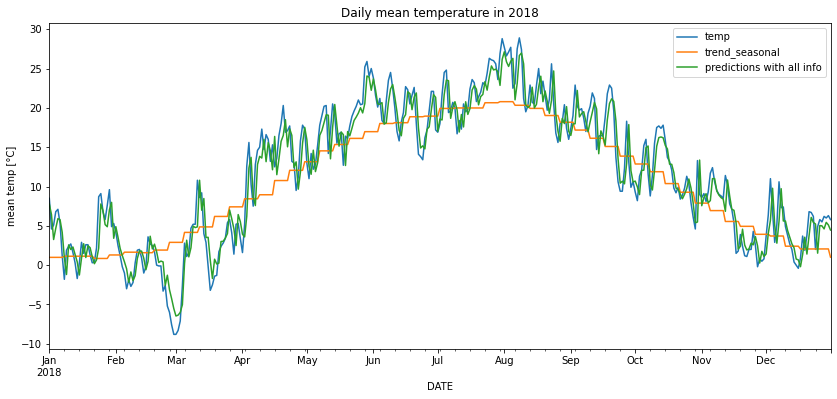

In [71]:
plot_temp(df_train.loc['1.1.2018':'31.12.2018'][['temp','trend_seasonal','predictions with all info']],title='Daily mean temperature in 2018')
plt.legend();

## Cross-validate the model

In [67]:
# Because we have a datetime index, we use TimeSeriesSplit here instead of random split:
ts_split = TimeSeriesSplit(n_splits=5)
time_series_split = ts_split.split(X_train, y_train) 

In [68]:
cvscore = cross_val_score(estimator=lr_all, X=X_train, y=y_train, cv=time_series_split)
print(f'The cross_validation scores for 5 splits are: \n{round(pd.DataFrame(cvscore)[0],2)}')

The cross_validation scores for 5 splits are: 
0    0.92
1    0.91
2    0.90
3    0.92
4    0.92
Name: 0, dtype: float64


## Test the model

In [100]:
df_test.shape

(365, 55)

In [101]:
X_test = df_test.drop(columns=['temp', 'trend'])

In [102]:
df_test['trend_seasonal'] = lr_seasonal.predict(X_test)
df_test.head()

temp  timestep      trend  week_2  week_3  week_4  week_5  week_6  \
DATE                                                                            
2019-11-02  11.3     26968  10.752143       0       0       0       0       0   
2019-11-03  10.9     26969  10.752210       0       0       0       0       0   
2019-11-04  10.4     26970  10.752278       0       0       0       0       0   
2019-11-05   9.5     26971  10.752346       0       0       0       0       0   
2019-11-06   8.2     26972  10.752413       0       0       0       0       0   

            week_7  week_8  ...  week_45  week_46  week_47  week_48  week_49  \
DATE                        ...                                                
2019-11-02       0       0  ...        0        0        0        0        0   
2019-11-03       0       0  ...        0        0        0        0        0   
2019-11-04       0       0  ...        1        0        0        0        0   
2019-11-05       0       0  ...        1        0        0        0        0   
2019-11-06       0       0  ...        1        0        0        0        0   

            week_50  week_51  week_52  week_53  trend_seasonal  
DATE                                                            
2019-11-02        0        0        0        0        7.910131  
2019-11-03        0        0        0        0        7.910190  
2019-11-04        0        0        0        0        6.959643  
2019-11-05        0        0        0        0        6.959701  
2019-11-06        0        0        0        0        6.959760  

[5 rows x 56 columns]

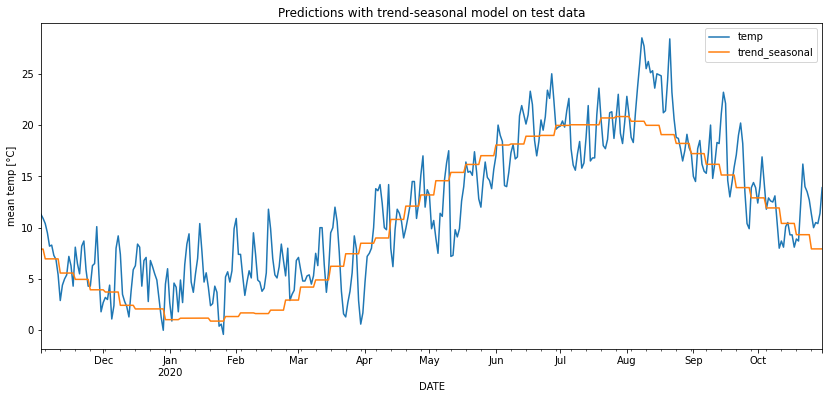

In [103]:
plot_temp(df_test[['temp','trend_seasonal']], title='Predictions with trend-seasonal model on test data')
plt.legend()

In [104]:
# Add the remainder to the test data:
df_test['remainder'] = df_test['temp'] - df_test['trend_seasonal']
# Add the lags to the test data:
df_test['lag1'] = df_test['remainder'].shift(1)
df_test['lag2'] = df_test['remainder'].shift(2)
df_test['lag3'] = df_test['remainder'].shift(3)
df_test['lag4'] = df_test['remainder'].shift(4)

In [105]:
df_test.head()

temp  timestep      trend  week_2  week_3  week_4  week_5  week_6  \
DATE                                                                            
2019-11-02  11.3     26968  10.752143       0       0       0       0       0   
2019-11-03  10.9     26969  10.752210       0       0       0       0       0   
2019-11-04  10.4     26970  10.752278       0       0       0       0       0   
2019-11-05   9.5     26971  10.752346       0       0       0       0       0   
2019-11-06   8.2     26972  10.752413       0       0       0       0       0   

            week_7  week_8  ...  week_50  week_51  week_52  week_53  \
DATE                        ...                                       
2019-11-02       0       0  ...        0        0        0        0   
2019-11-03       0       0  ...        0        0        0        0   
2019-11-04       0       0  ...        0        0        0        0   
2019-11-05       0       0  ...        0        0        0        0   
2019-11-06       0       0  ...        0        0        0        0   

            trend_seasonal  remainder      lag1      lag2      lag3      lag4  
DATE                                                                           
2019-11-02        7.910131   3.389869       NaN       NaN       NaN       NaN  
2019-11-03        7.910190   2.989810  3.389869       NaN       NaN       NaN  
2019-11-04        6.959643   3.440357  2.989810  3.389869       NaN       NaN  
2019-11-05        6.959701   2.540299  3.440357  2.989810  3.389869       NaN  
2019-11-06        6.959760   1.240240  2.540299  3.440357  2.989810  3.389869  

[5 rows x 61 columns]

In [106]:
#Replace the NaN values in first row:
df_test.loc['2019-11-02', 'lag1'] = df_train.loc['2019-11-01', 'remainder']
df_test.loc['2019-11-02', 'lag2'] = df_train.loc['2019-10-31', 'remainder']
df_test.loc['2019-11-02', 'lag3'] = df_train.loc['2019-10-30', 'remainder']
df_test.loc['2019-11-02', 'lag4'] = df_train.loc['2019-10-29', 'remainder']

In [107]:
#Replace the NaN values in 2nd row:
df_test.loc['2019-11-03', 'lag2'] = df_train.loc['2019-11-01', 'remainder']
df_test.loc['2019-11-03', 'lag3'] = df_train.loc['2019-10-31', 'remainder']
df_test.loc['2019-11-03', 'lag4'] = df_train.loc['2019-10-30', 'remainder']

In [108]:
#Replace the NaN values in 3rd row:
df_test.loc['2019-11-04', 'lag3'] = df_train.loc['2019-11-01', 'remainder']
df_test.loc['2019-11-04', 'lag4'] = df_train.loc['2019-10-31', 'remainder']

In [109]:
#Replace the NaN values in 4th row:
df_test.loc['2019-11-05', 'lag4'] = df_train.loc['2019-11-01', 'remainder']

In [110]:
df_test.head()

temp  timestep      trend  week_2  week_3  week_4  week_5  week_6  \
DATE                                                                            
2019-11-02  11.3     26968  10.752143       0       0       0       0       0   
2019-11-03  10.9     26969  10.752210       0       0       0       0       0   
2019-11-04  10.4     26970  10.752278       0       0       0       0       0   
2019-11-05   9.5     26971  10.752346       0       0       0       0       0   
2019-11-06   8.2     26972  10.752413       0       0       0       0       0   

            week_7  week_8  ...  week_50  week_51  week_52  week_53  \
DATE                        ...                                       
2019-11-02       0       0  ...        0        0        0        0   
2019-11-03       0       0  ...        0        0        0        0   
2019-11-04       0       0  ...        0        0        0        0   
2019-11-05       0       0  ...        0        0        0        0   
2019-11-06       0       0  ...        0        0        0        0   

            trend_seasonal  remainder      lag1      lag2      lag3      lag4  
DATE                                                                           
2019-11-02        7.910131   3.389869 -4.910073 -5.810014 -4.809956 -2.609897  
2019-11-03        7.910190   2.989810  3.389869 -4.910073 -5.810014 -4.809956  
2019-11-04        6.959643   3.440357  2.989810  3.389869 -4.910073 -5.810014  
2019-11-05        6.959701   2.540299  3.440357  2.989810  3.389869 -4.910073  
2019-11-06        6.959760   1.240240  2.540299  3.440357  2.989810  3.389869  

[5 rows x 61 columns]

In [111]:
X_test = df_test.drop(columns=['temp', 'trend', 'trend_seasonal', 'remainder'])

In [112]:
df_test['predictions with all info'] = lr_all.predict(X_test)
df_test.head()

temp  timestep      trend  week_2  week_3  week_4  week_5  week_6  \
DATE                                                                            
2019-11-02  11.3     26968  10.752143       0       0       0       0       0   
2019-11-03  10.9     26969  10.752210       0       0       0       0       0   
2019-11-04  10.4     26970  10.752278       0       0       0       0       0   
2019-11-05   9.5     26971  10.752346       0       0       0       0       0   
2019-11-06   8.2     26972  10.752413       0       0       0       0       0   

            week_7  week_8  ...  week_51  week_52  week_53  trend_seasonal  \
DATE                        ...                                              
2019-11-02       0       0  ...        0        0        0        7.910131   
2019-11-03       0       0  ...        0        0        0        7.910190   
2019-11-04       0       0  ...        0        0        0        6.959643   
2019-11-05       0       0  ...        0        0        0        6.959701   
2019-11-06       0       0  ...        0        0        0        6.959760   

            remainder      lag1      lag2      lag3      lag4  \
DATE                                                            
2019-11-02   3.389869 -4.910073 -5.810014 -4.809956 -2.609897   
2019-11-03   2.989810  3.389869 -4.910073 -5.810014 -4.809956   
2019-11-04   3.440357  2.989810  3.389869 -4.910073 -5.810014   
2019-11-05   2.540299  3.440357  2.989810  3.389869 -4.910073   
2019-11-06   1.240240  2.540299  3.440357  2.989810  3.389869   

            predictions with all info  
DATE                                   
2019-11-02                   4.267421  
2019-11-03                  11.618567  
2019-11-04                   8.509391  
2019-11-05                   9.528806  
2019-11-06                   8.776972  

[5 rows x 62 columns]

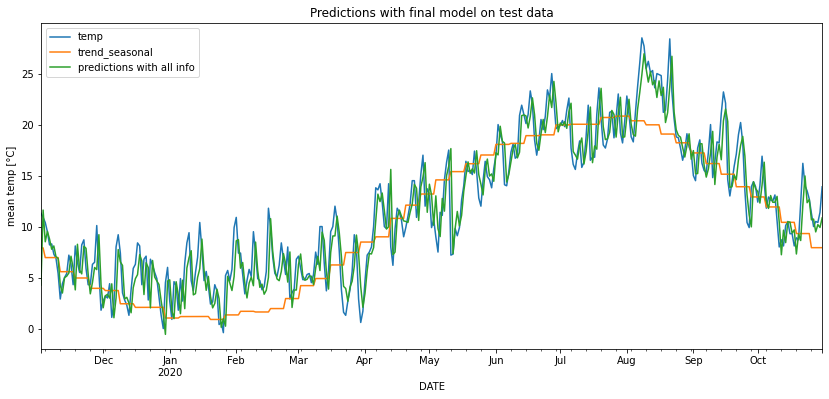

In [113]:
plot_temp(df_test[['temp','trend_seasonal', 'predictions with all info']], title='Predictions with final model on test data')
plt.legend();

In [114]:
round(lr_all.score(X_test, df_test['temp']),2)

0.89